In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


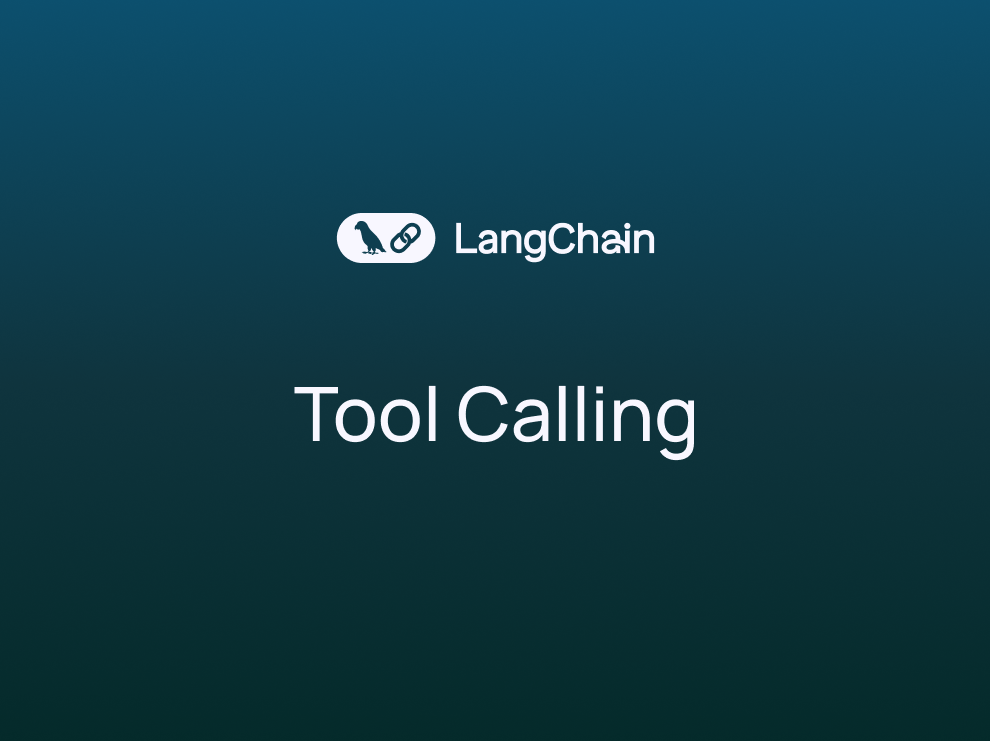

In [ ]:
from IPython.display import Image, display

display(Image('/content/drive/My Drive/AgentData/Tool-Calling-2.png'))

## Installing relevant libraries ⏬

In [13]:
!pip install --upgrade langchain langchain_community langchain_google_genai  langchainhub langchain-openai faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.8 MB/s eta 0:00:00




---



## Importing Libraries 📚

In [14]:
from google.colab import userdata
import os
from langchain.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, HumanMessage

## for email
import smtplib
from email.mime.text import MIMEText

#from langchain.agents import ToolAgent, ToolAgentExecutor

from langchain.agents import AgentExecutor, create_tool_calling_agent

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


## Initiating LLM 🤖

In [59]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, max_tokens=150)

# **Defining Tools**  🔨

#### Calculator tool ⏳

In [30]:
class Calculator:
    def calculate(self, expression: str) -> str:
        try:
            # Use Python's eval to compute the result safely
            result = eval(expression, {"__builtins__": None}, {})
            return str(result)
        except Exception as e:
            return f"Error: {e}"

In [31]:
@tool
def calculator(expression: str) -> str:
    """
    Perform arithmetic calculations.
    Input: A mathematical expression as a string (e.g., "2 + 2").
    Output: Result of the calculation as a string.
    """
    calc = Calculator()
    return calc.calculate(expression)

#### Email notification tool 📧

In [32]:
class SendUrgentEmailTool():

    def email_send(self) -> str:

        smtp_server = "smtp.gmail.com"
        smtp_port = 587
        sender_email = "ghazi.awesometech@gmail.com"
        sender_name = "AI Assistant - Meezan Bank"
        username = "ghazi.awesometech@gmail.com"
        password = ""  ## please add your own password -- Ghazi
        receiver_email = "sghazializaidi@gmail.com"

        # Updated subject and body
        subject = "🚨 Notification: Immediate Action Required 🚨"
        body = """
        <html>
        <body>
            <h2 style="color: #004d40; text-align: center;">URGENT NOTIFICATION</h2>
            <p style="font-size: 16px; font-family: Arial, sans-serif;">
                Dear Meezan Bank Team,
            </p>
            <p style="font-size: 16px; font-family: Arial, sans-serif;">
                A customer has raised a query that requires <b>IMMEDIATE HUMAN INTERVENTION</b>.
                Please review the matter promptly to ensure a seamless customer experience.
            </p>
            <p style="font-size: 16px; font-family: Arial, sans-serif;">
                <b>Customer Details:</b><br>
                - Query ID: [Insert Query ID]<br>
                - Timestamp: [Insert Timestamp]<br>
                - Priority Level: Urgent
            </p>
            <p style="font-size: 16px; font-family: Arial, sans-serif;">
                Best regards,<br>
                <b>AI Assistant</b><br>
                <b>Meezan Bank</b>
            </p>
        </body>
        </html>
        """

        # Create the email content
        msg = MIMEText(body, "html")
        msg['Subject'] = subject
        msg['From'] = f"{sender_name} <{sender_email}>"
        msg['To'] = receiver_email

        try:
            # Connect to the Gmail SMTP server and send the email
            with smtplib.SMTP(smtp_server, smtp_port) as server:
                server.starttls()
                server.login(username, password)
                server.send_message(msg)
                return "Urgent email sent successfully to Meezan Bank!"
        except Exception as e:
            return f"Failed to send email: {e}"


In [33]:
@tool
def email_sender() -> str:
    """
    Send an urgent email to the admin if requested by user.
    Input: No input required.
    Output: Notification send successfully.
    """
    sender = SendUrgentEmailTool()
    return sender.email_send()

## RAG (vector store) tool 📮

#### Document loading ⏳

In [34]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("/content/drive/My Drive/AgentData/InformationMeezanBank.txt")
documents = loader.load()

#### Embeddings from OpenAI -- storage FAISS 🏬

In [35]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(texts, embeddings)

retriever = db.as_retriever()

#### Initiating tool ♻

In [36]:
from langchain.tools.retriever import create_retriever_tool

information_tool = create_retriever_tool(
    retriever,
    "search_bank_Information",
    "Provide general information regarding Meezan Bank",
)

---

## Tool list 💪

In [37]:
# Define tools
tools = [calculator,email_sender,information_tool]

## Prompt to the LLM 👋

#### System prompt (Prompt template)

In [38]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful Meezan Bank assistant. Make sure to use the search_bank_Information for answering user query calculator tool for calculation, use email send tool when requested by user",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)


### Creating Agent 🤖 + 🔨 = 💪


In [39]:
agent = create_tool_calling_agent(llm, tools, prompt)

In [40]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

---

## Giving Agent Memory 🧠

In [44]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

### Initiating Memory

In [45]:
message_history = ChatMessageHistory()

In [46]:
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # This is needed because in most real world scenarios, a session id is needed
    # It isn't really used here because we are using a simple in memory ChatMessageHistory
    lambda session_id: message_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)

## Asking question to our AI Agent 😀

In [55]:
result = agent_with_chat_history.invoke(
    {"input": "how can I open bank account?"},
    config={"configurable": {"session_id": "<foo>"}},
)



> Entering new AgentExecutor chain...

Invoking: `search_bank_Information` with `{'query': 'how can I open bank account'}`


Meezan Bank AI Assistant Content
1. Account Services
Q: How can I open a bank account?
To open an account at Meezan Bank, you need to provide the following:
CNIC (Computerized National Identity Card) or a valid passport
Proof of address (utility bill, tenancy agreement, etc.)
Minimum initial deposit (varies by account type)
Two passport-size photographs
Biometric verification (at the branch)
Q: What types of accounts do you offer?
Meezan Bank offers various accounts, including:
Current Account: For everyday banking needs
Savings Account: To grow your savings with competitive profit rates
Kids Savings Account: For minors
Business Account: For SMEs and corporate clients
Q: What is the minimum balance requirement?
Current Account: No minimum balance required
Savings Account: PKR 1,000 (varies for other savings accounts)

4. Online Banking
Q: How do I re

#### Print the result ⚡

In [57]:
print(result['output'])

To open an account at Meezan Bank, you need to provide the following:
- CNIC (Computerized National Identity Card) or a valid passport
- Proof of address (utility bill, tenancy agreement, etc.)
- Minimum initial deposit (varies by account type)
- Two passport-size photographs
- Biometric verification (at the branch)

Meezan Bank offers various accounts, including:
- Current Account: For everyday banking needs
- Savings Account: To grow your savings with competitive profit rates
- Kids Savings Account: For minors
- Business Account: For SMEs and corporate clients

If you have any specific questions or need further assistance, feel free to ask!
